In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os

In [ ]:
# ------------------------------------------------
# 1️.Phase-Aligned TTFS Encoding Function
# ------------------------------------------------
@tf.function
def TTFS_Phase_encode(image, time_steps=10, smo_freq=5000, t_max_ms=295.0):
    """
    Phase-Aligned Time-To-First-Spike (TTFS) encoding for one image [H, W, C].
    - Aligns spike times to the next local maximum of a sinusoidal function.
    """
    image = tf.cast(image, tf.float32) / 255.0

    # 1. Standard TTFS Encoding: Time is in steps (0 to time_steps-1)
    ttfs_times_steps = (1.0 - image) * (time_steps - 1)
    ttfs_times_steps = tf.round(ttfs_times_steps) # [H, W, C]
    # Convert spike times to milliseconds
    ttfs_times_ms = ttfs_times_steps * (t_max_ms / (tf.cast(time_steps - 1, tf.float32) + 1e-6)) # [H, W, C]

    # 2. Phase Maximums Calculation (smo_freq=5000 Hz, smo_interval=0.2 ms)
    smo_interval_ms = 1000.0 / smo_freq
    smo_max_ms = tf.range(0.0, t_max_ms + smo_interval_ms/2.0, smo_interval_ms, dtype=tf.float32) # [N_phases]

    # 3. Align the TTFS output to the next local maximum (Vectorized)
    smo_max_broadcast = smo_max_ms[None, None, None, :] # [1, 1, 1, N_phases]
    ttfs_times_broadcast = ttfs_times_ms[..., None] # [H, W, C, 1]

    # Find the smallest phase max >= ttfs_time (the 'next' phase time)
    mask = tf.greater_equal(smo_max_broadcast, ttfs_times_broadcast)
    # Use a large number for False mask elements
    inf = tf.cast(tf.reduce_max(smo_max_ms) * 2.0, tf.float32)
    next_phase_time_ms = tf.where(mask, smo_max_broadcast, inf)
    aligned_times_ms = tf.reduce_min(next_phase_time_ms, axis=-1) # [H, W, C]

    # 4. Convert back to time steps (0 to time_steps-1)
    aligned_times_steps = aligned_times_ms * (tf.cast(time_steps - 1, tf.float32) + 1e-6) / t_max_ms
    aligned_times_steps = tf.clip_by_value(aligned_times_steps, 0.0, tf.cast(time_steps - 1, tf.float32))
    aligned_times_steps = tf.round(aligned_times_steps) # Final spike time in discrete steps [H, W, C]

    # 5. Create the binary spike tensor [time_steps, H, W, C]
    time_range = tf.range(time_steps, dtype=tf.float32)[:, None, None, None]
    spikes = tf.cast(tf.equal(time_range, aligned_times_steps[None, ...]), tf.float32)

    return spikes  # shape: [time_steps, H, W, C]

In [ ]:
# ------------------------------------------------
# 2️.Load CIFAR-10 Dataset & Constants
# ------------------------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
num_classes = 10
time_steps = 10
batch_size = 64
t_max_ms = 295.0  # Maximum time in milliseconds for the Phase Encoder

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# ------------------------------------------------
# 3️.Visualization with Spike Overlay + GIF
# ------------------------------------------------
def visualize_and_save_ttfs_overlay(image, label, time_steps=10, save_dir="ttfs_gifs_overlay", sample_id=0):
    """Visualize Phase-Aligned TTFS spikes overlayed on the original image and save as GIF."""
    os.makedirs(save_dir, exist_ok=True)
    # Updated to call the new TTFS_Phase_encode function
    spikes = TTFS_Phase_encode(image, time_steps=time_steps, t_max_ms=t_max_ms)
    spikes_np = spikes.numpy()  # (time_steps, H, W, C)
    img_norm = image / 255.0

    # Compute spike time map (earliest spikes = bright)
    spike_time_map = np.argmax(spikes_np[::-1], axis=0)
    spike_time_map = time_steps - spike_time_map

    # Static map of spike timing
    plt.figure(figsize=(4, 4))
    plt.imshow(spike_time_map[:, :, 0], cmap="inferno")
    plt.title(f"Phase-Aligned Spike Timing Map (sample {sample_id})")
    plt.axis("off")
    plt.savefig(os.path.join(save_dir, f"spike_timing_{sample_id}.png"))
    plt.close()

    # Animated GIF: overlay spikes on original image
    frames = []
    for t in range(time_steps):
        # Binary spike mask for this timestep
        mask = spikes_np[t]
        overlay = img_norm.copy()

        # Red overlay for active spikes
        overlay[:, :, 0] = np.clip(overlay[:, :, 0] + 0.8 * mask[:, :, 0], 0, 1)

        frame = (overlay * 255).astype(np.uint8)
        frames.append(frame)

    gif_path = os.path.join(save_dir, f"ttfs_overlay_{sample_id}.gif")
    imageio.mimsave(gif_path, frames, fps=2)  # 2 frames per second
    print(f"Saved overlay GIF: {gif_path}")


# Generate a few overlayed GIFs before training
for i in range(2):
    visualize_and_save_ttfs_overlay(x_train[i], y_train[i], time_steps=time_steps, sample_id=i)


Saved overlay GIF: ttfs_gifs_overlay/ttfs_overlay_0.gif
Saved overlay GIF: ttfs_gifs_overlay/ttfs_overlay_1.gif


In [ ]:
# ------------------------------------------------
# 4️.On-the-Fly tf.data Pipeline
# ------------------------------------------------
def encode_fn(image, label):
    # Updated to call the new TTFS_Phase_encode function
    spikes = TTFS_Phase_encode(image, time_steps, t_max_ms=t_max_ms)
    return spikes, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(10000)
    .map(encode_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(encode_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# ------------------------------------------------
# 5️.Model Definition (TimeDistributed Conv2D)
# ------------------------------------------------
def create_ttfs_cifar10_model(time_steps=10, num_classes=10):
    model = models.Sequential([
        layers.Input(shape=(time_steps, 32, 32, 3)),

        layers.TimeDistributed(layers.Conv2D(32, (3, 3), padding='same', activation='relu')),
        layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
        layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu')),
        layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
        layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu')),
        layers.TimeDistributed(layers.Flatten()),

        # Integrate spike activity over time
        layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# ------------------------------------------------
# 6️.Train the Model
# ------------------------------------------------
model = create_ttfs_cifar10_model(time_steps, num_classes)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 32, 32, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 16, 16, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 8, 8, 128)  │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 8192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,193,226 (8.37 MB)

 Trainable params: 2,193,226 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 90s 99ms/step - accuracy: 0.2216 - loss: 2.1084 - val_accuracy: 0.4205 - val_loss: 1.6282
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3974 - loss: 1.6749 - val_accuracy: 0.4704 - val_loss: 1.4938
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4442 - loss: 1.5578 - val_accuracy: 0.5069 - val_loss: 1.3976
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4814 - loss: 1.4740 - val_accuracy: 0.5273 - val_loss: 1.3357
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5053 - loss: 1.4137 - val_accuracy: 0.5539 - val_loss: 1.2750
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5228 - loss: 1.3576 - val_accuracy: 0.5635 - val_loss: 1.2364
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5422 - loss: 1.3136 - val_accuracy: 0.5806 - val_loss: 1.1947
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5539 - loss: 1.2807 - val_accuracy: 

In [ ]:

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    verbose=1
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7021 - loss: 0.8558 - val_accuracy: 0.6919 - val_loss: 0.8828
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7062 - loss: 0.8421 - val_accuracy: 0.6946 - val_loss: 0.8840
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7062 - loss: 0.8421 - val_accuracy: 0.7039 - val_loss: 0.8686
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7145 - loss: 0.8208 - val_accuracy: 0.6952 - val_loss: 0.8788
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7172 - loss: 0.8081 - val_accuracy: 0.6944 - val_loss: 0.8755
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7234 - loss: 0.7958 - val_accuracy: 0.6964 - val_loss: 0.8712
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7263 - loss: 0.7884 - val_accuracy: 0.6960 - val_loss: 0.8808
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7337 - loss: 0.7682 - val_accuracy: 0.

In [ ]:

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=40,
    verbose=1
)

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8071 - loss: 0.5399 - val_accuracy: 0.7090 - val_loss: 0.9135
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8107 - loss: 0.5287 - val_accuracy: 0.7153 - val_loss: 0.8811
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8146 - loss: 0.5192 - val_accuracy: 0.7068 - val_loss: 0.9380
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8185 - loss: 0.5142 - val_accuracy: 0.7079 - val_loss: 0.9280
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8209 - loss: 0.4964 - val_accuracy: 0.7098 - val_loss: 0.9593
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8196 - loss: 0.4918 - val_accuracy: 0.7130 - val_loss: 0.9534
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8240 - loss: 0.4874 - val_accuracy: 0.7094 - val_loss: 0.9342
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8304 - loss: 0.4702 - val_accuracy: 0.

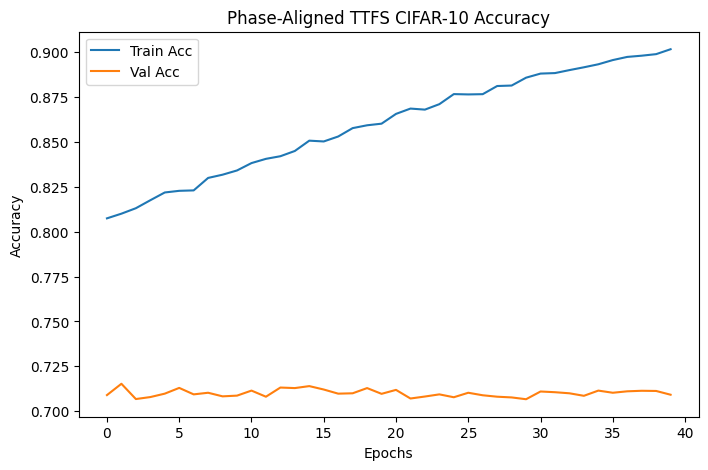

In [ ]:
# ------------------------------------------------
# 7️⃣ Plot Accuracy Curves
# ------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Phase-Aligned TTFS CIFAR-10 Accuracy')
plt.legend()
plt.show()
